In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xgboost as xgb

from time import time
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LogisticRegression, ElasticNet
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from pyearth import Earth

# Conceptual exercises

## Cost functions for classification trees

Consider the Gini index, classification error, and cross-entropy in a simple classification setting with two classes.

### Create a single plot in Python or R that displays each of these quantities as a function of $\hat{p}_{m1}$. The x-axis should display $\hat{p}_{m1}$, ranging from 0 to 1, and the y-axis should display the value of the Gini index, classification error, and cross-entropy.

In [2]:
compute_gini = lambda p: 2*p*(1-p)
compute_clerr = lambda p: 1-max(p,1-p)
compute_crsentr = lambda p: -p*np.log(p)-(1-p)*np.log(1-p)

In [3]:
p_lst = np.arange(0.05, 1, 0.05)
gini = [compute_gini(p) for p in p_lst]
clerr = [compute_clerr(p) for p in p_lst]
crsentr = [compute_crsentr(p) for p in p_lst]

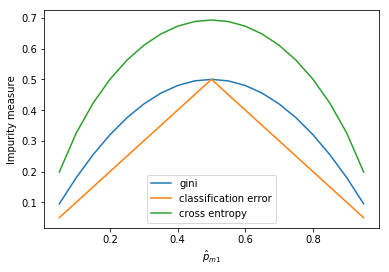

In [4]:
plt.plot(p_lst, gini, label = 'gini')
plt.plot(p_lst, clerr, label='classification error')
plt.plot(p_lst, crsentr, label='cross entropy')
plt.legend()
plt.xlabel(r"$\hat{p}_{m1}$"); plt.ylabel("Impurity measure")
plt.show()

### Of these three possible cost functions, which would be best to use when growing a decision tree? Which would be best to use when pruning a decision tree? Why?

When growing a decision tree, we want the cost functions that can generate higher node purity. In that case, we normally would use Gini index, or cross entropy to grow the tree, as they are more sensitive to node purity. When pruning a tree, we want to make sure the trained decision tree is not overfitting the training set data. Therefore, we would use the classification to prune the tree.

## Predictions from tree-aggregation methods

Suppose we produce ten bootstrapped samples from a data set containing red and green classes. We then apply a classification tree to each of the bootstrapped samples and, for a specific value of $X$, produce 10 estimates of $Pr(Class\;is\;Red\;|\;X)$: 0.1, 0.15, 0.2, 0.2, 0.55, 0.6, 0.6, 0.65, 0.7, 0.75

There are two common ways to combine these results together into a single class prediction. One is the majority vote approach, and the second is to classify based on the average probability.

### What is the final classification under the majority vote approach?

In [5]:
p_red = np.array([0.1, 0.15, 0.2, 0.2, 0.55, 0.6, 0.6, 0.65, 0.7, 0.75])

In [6]:
vote_red = 1*(p_red > 0.5).sum()
vote_green = 1*(p_red <= 0.5).sum()
print(vote_red, vote_green)

6 4


By aggregating all these tree models, we can see that more of them classified this sample as red. So, the final classification is red.

### What is the final classification based on the average probability?

In [7]:
avg = p_red.mean()
print(avg)

0.45


By averaging all these probailities, the probability that the sample is red is 0.45(less than 0.5). Therefore, we would classify the sample as green.

### What is $Pr(Class\;is\;Red\;|\;X)$? That is, what is the probability this specific observation is “Red” given the 10 classification trees? Compare the result if you calculate the probability using the voting proportions from the majority vote approach versus averaging each of the individual classification tree predicted probabilities. Which approach is correct?

In [8]:
print("By using the majority vote approach, the probaility is {}".format(vote_red/10))
print("By using the average probability approach, the probaility is {}".format(avg))

By using the majority vote approach, the probaility is 0.6
By using the average probability approach, the probaility is 0.45


I think the average probability will is more correct in a sense it captures more information on how confidenty we are about the prediction. For example, a sample with a probability of 0.6 to be red will be calculated as 1 in the majority vote approach, whereas average can maintain the probability prediction as 0.6. So, the avearge probability is a more solid model.

## Standardization using xgboost

Evaluate the performance of xgboost using gss_train.csv, predicting egalit_scale as a function of all the other covariates. Estimate two separate models with 1000 trees using 5-fold cross-validation (leave all other hyperparameter settings at their default values):

* One with unstandardized predictors
* One with standardized predictors

Record the time it takes your computer to estimate each model and compare the performance of each model based on the CV MSE.

In [9]:
gss_train = pd.read_csv("./data/gss_train.csv", dtype=float)

x = gss_train.drop('egalit_scale', axis=1).values
y = gss_train['egalit_scale'].values

In [10]:
data_dmatrix_unscaled = xgb.DMatrix(data=x,label=y)
x_scaled = (x-x.mean(0))/np.std(x, axis=0)
data_dmatrix_scaled = xgb.DMatrix(data=x_scaled, label=y)

In [11]:
%%capture
# build the unscaled model
params = {"objective":"reg:linear",'colsample_bytree': 1,'learning_rate': 0.1,'max_depth':3}
s = time()
cv_results_unscaled = xgb.cv(dtrain=data_dmatrix_unscaled, params=params, nfold=5,
                    num_boost_round=1000, metrics="rmse", as_pandas=True, seed=123)
time_unscaled = time()-s

In [12]:
%%capture
# Build the unscaled model
params = {"objective":"reg:linear",'colsample_bytree': 1,'learning_rate': 0.1,'max_depth':3}
s = time()
cv_results_scaled = xgb.cv(dtrain=data_dmatrix_scaled, params=params, nfold=5,
                    num_boost_round=1000, metrics="rmse", as_pandas=True, seed=123)
time_scaled = time()-s

### Do the models perform substantially differently in terms of error? Why or why not?

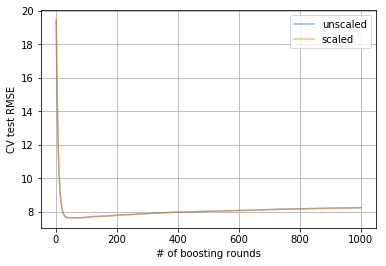

In [13]:
plt.plot(range(1,1001), cv_results_unscaled['test-rmse-mean'], alpha=0.5, label = 'unscaled')
plt.plot(range(1,1001), cv_results_scaled['test-rmse-mean'], alpha=0.5, label = 'scaled')
plt.xlabel("# of boosting rounds"); plt.ylabel('CV test RMSE')
plt.legend()
plt.grid()
plt.show()

As we can see from the graph, the two models do not differ in terms of prediction error. This is because this is a binary spiliting algorithm, so the distance to the original points does not matter. The splitting decision is not affected by whether the predicting variables are scaled or not.

### Do the models perform substantially differently in terms of computational efficiency? Why or why not?

In [14]:
print("The XGBoost with unscaled predictors took {} seconds".format(time_unscaled))
print("The XGBoost with scaled predictors took {} seconds".format(time_scaled))

The XGBoost with unscaled predictors took 10.5231032371521 seconds
The XGBoost with scaled predictors took 10.32926607131958 seconds


Both models can run pretty efficiently and their time consumption is very similar. There is not much efficiency gain or loss from scaling, as the global loss function is convex, and the models are basically following the same branching strategy. Hence, there is not much difference regarding predictor scaling.

# Predicting attitudes towards racist college professors

In [15]:
# import the data
gss_train = pd.read_csv("./data/gss_train.csv")
gss_test = pd.read_csv('./data/gss_test.csv')

y_train = gss_train['colrac'].values
x_train = gss_train.drop(['colrac'], axis=1).values
y_test = gss_test['colrac'].values
x_test = gss_test.drop(['colrac'], axis=1).values

model_lst = []

## Estimate statistical models

### Logistic Regression

In [16]:
model_lst.append(LogisticRegression(C=1e6))

### Naive Bayes

In [17]:
model_lst.append(GaussianNB())

### K-nearest neighbors

In [18]:
errors_knn = []
for k in range(1,11):
    model = KNeighborsClassifier(n_neighbors=k)
    error = 1-np.mean(cross_val_score(model, x_train, y_train, cv=KFold(5), scoring='accuracy'))
    errors_knn.append(error)

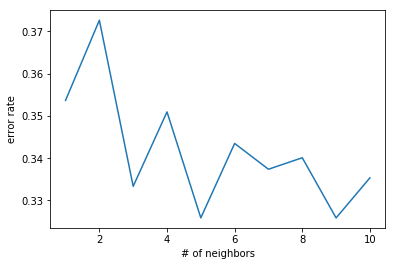

The error rate is the smallest at K=9


In [19]:
plt.plot(range(1,11), errors_knn)
plt.xlabel("# of neighbors"); plt.ylabel("error rate")
plt.show()

print("The error rate is the smallest at K={}".format(np.argmin(errors_knn)+1))

In [20]:
model_lst.append(KNeighborsClassifier(n_neighbors=np.argmin(errors_knn)+1))

### Ridge regression

In [21]:
errors_ridge = []
c_lst = np.logspace(-2,1, 30)
for c in c_lst:
    model = LogisticRegression(C=c, penalty='l1')
    error = 1-np.mean(cross_val_score(model, x_train, y_train, cv=KFold(5), scoring='accuracy'))
    errors_ridge.append(error)

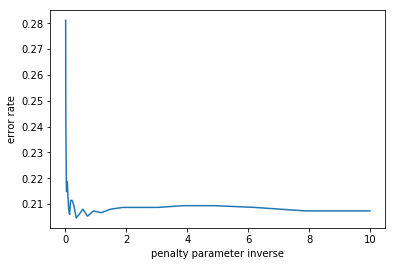

The error rate is the smallest when C=0.3562247890262442


In [22]:
plt.plot(c_lst, errors_ridge)
plt.xlabel("penalty parameter inverse"); plt.ylabel("error rate")
plt.show()

print("The error rate is the smallest when C={}".format(c_lst[np.argmin(errors_ridge)]))

In [23]:
model_lst.append(LogisticRegression(C=c_lst[np.argmin(errors_ridge)], penalty='l1'))

### Lasso regression

In [24]:
errors_lasso = []
c_lst = np.logspace(-2,1, 30)
for c in c_lst:
    model = LogisticRegression(C=c, penalty='l2')
    error = 1-np.mean(cross_val_score(model, x_train, y_train, cv=KFold(5), scoring='accuracy'))
    errors_lasso.append(error)

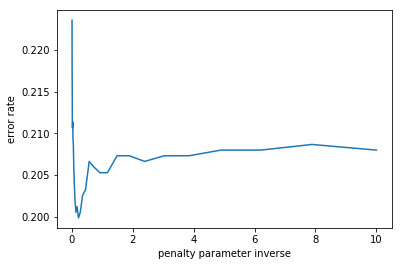

The error rate is the smallest when C=0.2212216291070449


In [25]:
plt.plot(c_lst, errors_lasso)
plt.xlabel("penalty parameter inverse"); plt.ylabel("error rate")
plt.show()

print("The error rate is the smallest when C={}".format(c_lst[np.argmin(errors_lasso)]))

In [26]:
model_lst.append(LogisticRegression(C=c_lst[np.argmin(errors_lasso)], penalty='l2'))

### MARS

In [27]:
model_lst.append(Pipeline([('earth', Earth()),('logistic', LogisticRegression())]))

### Decision Tree

In [28]:
errors_dt = []
for d in range(2, 11):
    model = DecisionTreeClassifier(max_depth=d)
    error = 1-np.mean(cross_val_score(model, x_train, y_train, cv=KFold(5), scoring='accuracy'))
    errors_dt.append(error)

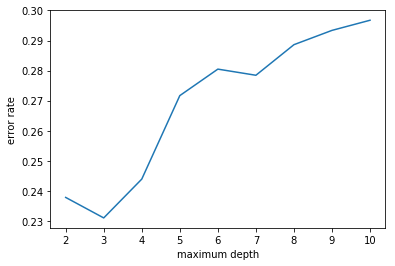

The error rate is the smallest when d=3


In [29]:
plt.plot(range(2, 11), errors_dt)
plt.xlabel("maximum depth"); plt.ylabel("error rate")
plt.show()

print("The error rate is the smallest when d={}".format(np.argmin(errors_dt)+2))

In [30]:
model_lst.append(DecisionTreeClassifier(max_depth=np.argmin(errors_dt)+2))

### Bagging

In [31]:
errors_bagging = []
n_tree = np.arange(5, 101, 5)
for n in n_tree:
    model = BaggingClassifier(n_estimators=n)
    error = 1-np.mean(cross_val_score(model, x_train, y_train, cv=KFold(5), scoring='accuracy'))
    errors_bagging.append(error)

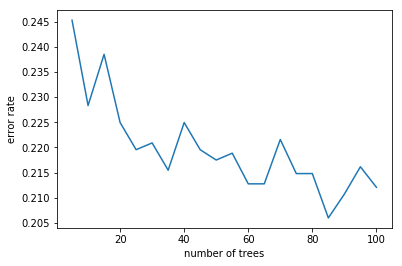

The error rate is the smallest when n=85


In [32]:
plt.plot(n_tree, errors_bagging)
plt.xlabel("number of trees"); plt.ylabel("error rate")
plt.show()

print("The error rate is the smallest when n={}".format(n_tree[np.argmin(errors_bagging)]))

In [33]:
model_lst.append(BaggingClassifier(n_estimators=n_tree[np.argmin(errors_bagging)]))

### Random forest

In [34]:
n_tree = np.arange(10, 101, 10)
max_depth = np.arange(2, 11)
errors_rf = []; opt_depth = []
for n in n_tree:
    errors = []
    for d in max_depth:
        model = RandomForestClassifier(n_estimators=n, max_depth=d)
        error = 1-np.mean(cross_val_score(model, x_train, y_train, cv=KFold(5), scoring='accuracy'))
        errors.append(error)
    idx = np.argmin(errors)
    errors_rf.append(errors[idx])
    opt_depth.append(max_depth[idx])

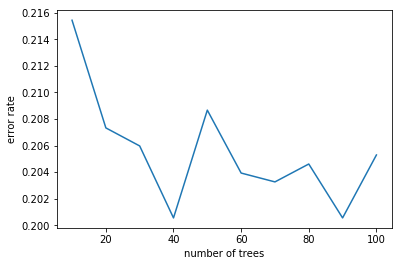

The error rate is the smallest when n=40 and max-depth=9


In [35]:
plt.plot(n_tree, errors_rf)
plt.xlabel("number of trees"); plt.ylabel("error rate")
plt.show()

opt_idx = np.argmin(errors_rf)
print("The error rate is the smallest when n={} and max-depth={}".format(n_tree[opt_idx], opt_depth[opt_idx]))

In [36]:
model_lst.append(RandomForestClassifier(n_estimators=n_tree[opt_idx], max_depth=opt_depth[opt_idx]))

### Boosting

In [37]:
%%capture
n_tree = np.arange(10, 101, 10)
max_depth = np.arange(2, 11)
errors_xgboost = []; opt_depth = []
for n in n_tree:
    errors = []
    for d in max_depth:
        model = xgb.XGBClassifier(objective="binary:logistic", n_estimators=n, max_depth=d)
        error = 1-np.mean(cross_val_score(model, x_train, y_train, cv=KFold(5), scoring='accuracy'))
        errors.append(error)
    idx = np.argmin(errors)
    errors_xgboost.append(errors[idx])
    opt_depth.append(max_depth[idx])

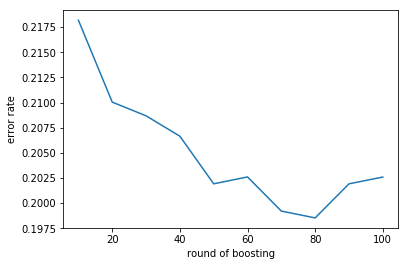

The error rate is the smallest when n=80 and max-depth=4


In [38]:
plt.plot(n_tree, errors_xgboost)
plt.xlabel("round of boosting"); plt.ylabel("error rate")
plt.show()

opt_idx = np.argmin(errors_xgboost)
print("The error rate is the smallest when n={} and max-depth={}".format(n_tree[opt_idx], opt_depth[opt_idx]))

In [39]:
model_lst.append(xgb.XGBClassifier(objective="binary:logistic", n_estimators=n_tree[opt_idx], max_depth=opt_depth[opt_idx]))

### Elastic net

Seems like that the Scikit-Learn's Logistic Regression can't implement the L1 and L2 penalty at the same time. Therefore, I would run a simple ElasticNet Linear Probability Regression first

In [40]:
mses_en = []; opt_alpha = []
alpha_lst = np.logspace(-2, 1, 30);
ratio_lst = np.arange(0.05, 1, 0.05)
for r in ratio_lst:
    mses = []
    for a in alpha_lst:
        model = ElasticNet(alpha=a, l1_ratio=r)
        mse = -np.mean(cross_val_score(model, x_train, y_train, cv=KFold(5), scoring='neg_mean_squared_error'))
        mses.append(mse)
    idx = np.argmin(mses)
    mses_en.append(mses[idx])
    opt_alpha.append(alpha_lst[idx])

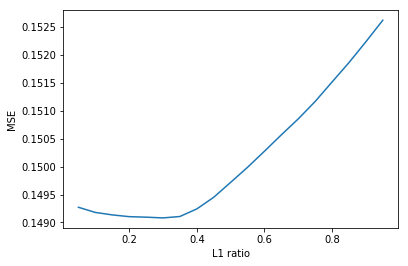

The MSE is the smallest when L1-ratio=0.30 and alpha=0.01


In [41]:
plt.plot(ratio_lst, mses_en)
plt.xlabel("L1 ratio"); plt.ylabel("MSE")
plt.show()

idx = np.argmin(mses_en)
print("The MSE is the smallest when L1-ratio={:.2f} and alpha={}".format(ratio_lst[idx], opt_alpha[idx]))

In [42]:
model_lst.append(ElasticNet(alpha=opt_alpha[idx], l1_ratio=ratio_lst[idx]))

## Evaluate statistical models

In [43]:
model_lst[-1]

ElasticNet(alpha=0.01, copy_X=True, fit_intercept=True, l1_ratio=0.3,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [44]:
%%capture
error_lst = [1-np.mean(cross_val_score(model, x_train, y_train, cv=KFold(5), scoring='accuracy')) 
             for model in model_lst[:-1]]
auc_lst = [np.mean(cross_val_score(model, x_train, y_train, cv=KFold(5), scoring='roc_auc')) 
           for model in model_lst[:-1]]

In [45]:
# Calaculate the CV error rate and AUC for ElasticNet model manually
model = model_lst[-1]
np.random.seed(1234)
idx = np.random.choice(5, x_train.shape[0])
errors = []; aucs = []
for i in range(5):
    x = x_train[idx!=i]; y = y_train[idx!=i]
    res = model.fit(X=x, y=y)
    pred = 1*(res.predict(x_train[idx==i])>0.5); y_true = y_train[idx==i]
    error = 1 - accuracy_score(y_true, pred); errors.append(error)
    auc = roc_auc_score(y_true, pred); aucs.append(auc)
error_lst.append(np.mean(errors))
auc_lst.append(np.mean(aucs))

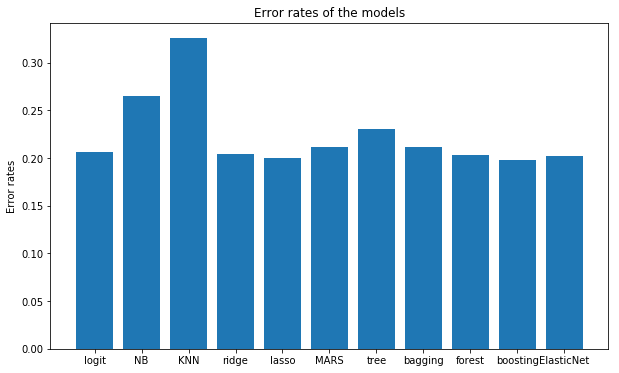

In [46]:
plt.figure(figsize=(10,6))
plt.bar(range(len(model_lst)), error_lst)
plt.ylabel('Error rates')
plt.title('Error rates of the models')
plt.xticks(range(len(model_lst)), ('logit', 'NB', 'KNN', 'ridge', 'lasso', 'MARS', 'tree'
                                   , 'bagging', 'forest', 'boosting', 'ElasticNet'))
plt.show()

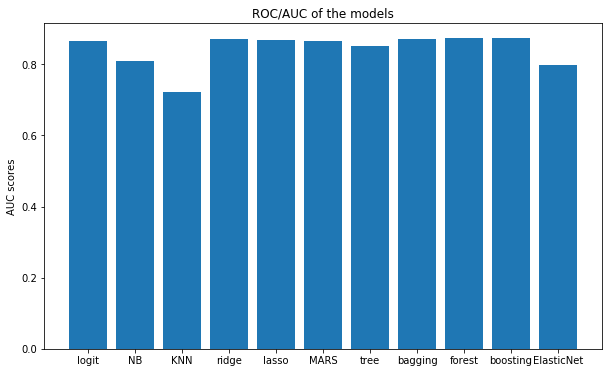

In [47]:
plt.figure(figsize=(10,6))
plt.bar(range(len(model_lst)), auc_lst)
plt.ylabel('AUC scores')
plt.title('ROC/AUC of the models')
plt.xticks(range(len(model_lst)), ('logit', 'NB', 'KNN', 'ridge', 'lasso', 'MARS', 'tree'
                                   , 'bagging', 'forest', 'boosting', 'ElasticNet'))
plt.show()

The lasso model has the lowest error rates of all, and the random forest model hits the top AUC score that has a slight edge over lasso. Therefore, I would argue that lasso has the best cross validation performance and I will proceed with the lasso model.

## Interpret the best model

I will proceed with the lasso model.

### Feature Importance

In [48]:
from skater.model import InMemoryModel
from skater.core.explanations import Interpretation

In [49]:
lasso = model_lst[4]; lasso.fit(x_train, y_train)
model = InMemoryModel(lasso.predict_proba, examples = x_train)
interpreter = Interpretation(x_train)
importance = interpreter.feature_importance.feature_importance(model)

2019-03-04 16:06:03,615 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progress_bar=False


[55/55] features ████████████████████ Time elapsed: 4 seconds

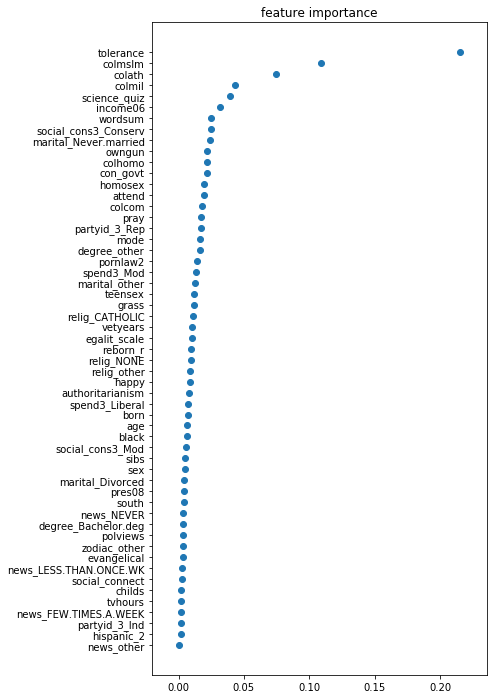

In [50]:
features = np.array(gss_train.drop(['colrac'], axis=1).columns)
plt.figure(figsize=(6,12))
plt.scatter(importance, np.arange(0,len(features)))
_ = plt.yticks(np.arange(0,len(features)), features[list(importance.index)])
_ = plt.title('feature importance')

As we can see from the feature importance ranking, the most important feature here is the tolerance, colmslm, and colath.

### PDPs/ICE

In [51]:
from pycebox.ice import ice, ice_plot

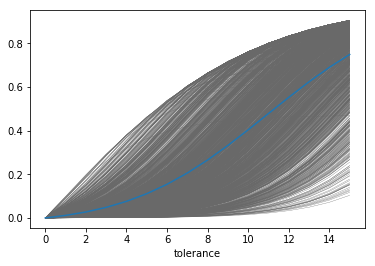

In [52]:
ice_df = ice(gss_train.drop(['colrac'], axis=1), 'tolerance', lambda x:lasso.predict_proba(x)[:,0])
ice_plot(ice_df, c='dimgray', linewidth=0.3, plot_pdp=True, centered=True)
_ = plt.xlabel('tolerance')

The tolerance is positively associated with colrac.

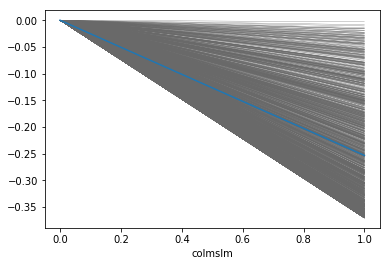

In [53]:
ice_df = ice(gss_train.drop(['colrac'], axis=1), 'colmslm', lambda x:lasso.predict_proba(x)[:,0])
ice_plot(ice_df, c='dimgray', linewidth=0.3, plot_pdp=True, centered=True)
_ = plt.xlabel('colmslm')

The colmslm is negatively associated with colrac.

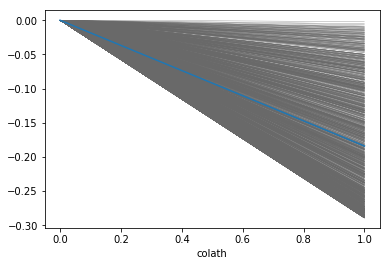

In [54]:
ice_df = ice(gss_train.drop(['colrac'], axis=1), 'colath', lambda x:lasso.predict_proba(x)[:,0])
ice_plot(ice_df, c='dimgray', linewidth=0.3, plot_pdp=True, centered=True)
_ = plt.xlabel('colath')

The colath is negatively associated with colrac.

### LIME

In [55]:
import lime
import lime.lime_tabular

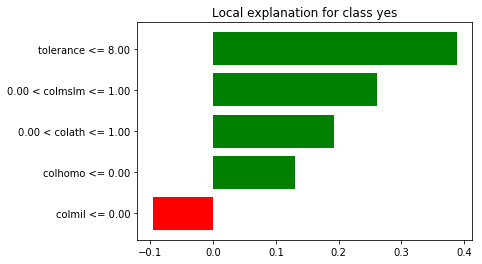

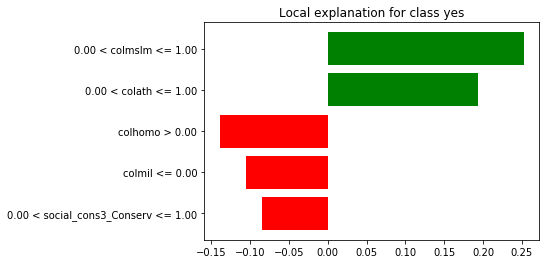

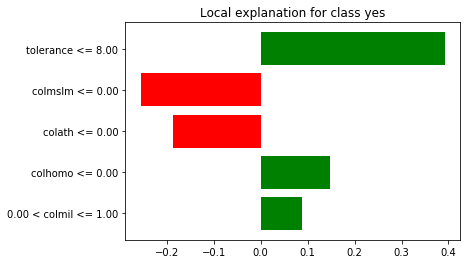

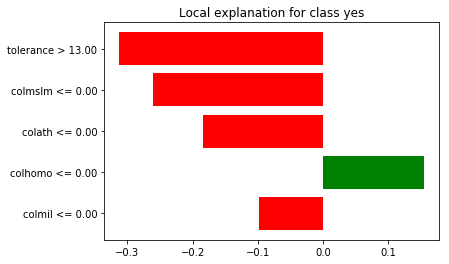

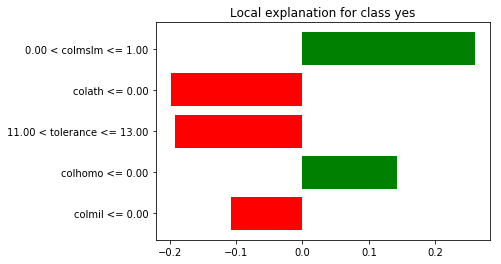

In [56]:
local = pd.read_csv('./data/gss_local.csv').drop(['colrac'], axis=1)
explainer = lime.lime_tabular.LimeTabularExplainer(x_train, feature_names=np.array(gss_train.drop(['colrac'], axis=1).columns), 
                                                   class_names=['colrac:no', 'yes'], feature_selection='auto')
predictor = lambda x:lasso.predict_proba(x)
for i in range(5):
    exp = explainer.explain_instance(local.loc[i].values, predictor, num_features=5)
    exp.as_pyplot_figure()

From the first five observations of the gss_local dataset, we can see that the most important features are still tolerance, colmslm, colath, colhomo, colmil. But the direction of their effects vary among these five samples.

## Evaluate the best model

In [57]:
pred = lasso.predict(x_test)
error_test = 1 - accuracy_score(y_test, pred)
auc_test = roc_auc_score(y_test, pred)

In [58]:
print("The CV error rate on the training set is {}".format(error_lst[4]))
print("The error rate on the testing set is {}".format(error_test))

The CV error rate on the training set is 0.1998602840128264
The error rate on the testing set is 0.2210953346855984


In [59]:
print("The CV AUC score on the training set is {}".format(auc_lst[4]))
print("The AUC score on the testing set is {}".format(auc_test))

The CV AUC score on the training set is 0.8686095209404975
The AUC score on the testing set is 0.7744372724263489


As we can see from these comparisons, the error rate is a bit inflated on the testing set, while the AUC score is deflated on the testing set. The model does not generalize very will externally.